# Motion Segmentation Model - Deep Error Analysis

This notebook provides comprehensive analysis of motion segmentation model performance, focusing on understanding when and why the model makes errors.

## Analysis includes:
- Transition length analysis (short vs long transitions)
- Transition position analysis (beginning, middle, end)
- Sequence length impact
- Confidence/uncertainty analysis
- Temporal error patterns
- Class imbalance effects

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Add your project to path
sys.path.append('/home/nadir/tmr-code')

# Import your project modules
from src.config import read_config
from src.load import load_model_from_cfg
from hydra.utils import instantiate
import pytorch_lightning as pl

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Configuration - MODIFY THESE PATHS
RUN_DIR = "/home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20"  # Change to your model path
DEVICE = "cuda:1"  # Change if needed
CKPT_NAME = "best"
DATA_DIR = "/home/nadir/disk/datasets/babel-for-validation"

print(f"Analyzing model from: {RUN_DIR}")
print(f"Using device: {DEVICE}")

Analyzing model from: /home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20
Using device: cuda:1


In [3]:
# Load model configuration and setup
cfg = read_config(RUN_DIR)
pl.seed_everything(cfg.seed)

# Extract window size from run directory
window_size = int(RUN_DIR.split("_mlp_")[1])
print(f"Window size: {window_size}")

# Load model
model = load_model_from_cfg(cfg, CKPT_NAME, eval_mode=True, device=DEVICE)
model = model.eval()
print("Model loaded successfully")

# Load dataset
dataset = instantiate(
    {
        "_target_": "src.data.windowed_dataset.WindowedDataset",
    },
    dir=DATA_DIR,
    window_size=window_size,
    split="all",
    for_validation=True,
    normalize=False,
    balanced=False
)

# Load normalization statistics
normalization_statistics = torch.load(os.path.join(dataset.dir, "motion_normalization_stats.pt"))
mean = normalization_statistics["mean"]
std = normalization_statistics["std"]

print(f"Dataset loaded with {len(dataset)} sequences")
print(f"Mean shape: {mean.shape}, Std shape: {std.shape}")

Global seed set to 1234


Window size: 20
Model loaded successfully
[slef.dir]: /home/nadir/disk/datasets/babel-for-validation/20-1
here


[preloading]: 100%|██████████| 1538/1538 [00:00<00:00, 3894.70it/s]

Dataset loaded with 1538 sequences
Mean shape: torch.Size([22, 3]), Std shape: torch.Size([22, 3])


In [4]:
# Load vote manager (using score-based by default)
vote_manager = instantiate({
    "_target_": "src.model.vote_managers.score_based_vote_manager.ScoreBasedVoteManager"
})

print(f"Vote manager loaded: {type(vote_manager).__name__}")

InstantiationException: Error locating target 'src.model.vote_managers.score_based_vote_manager.ScoreBasedVoteManager', set env var HYDRA_FULL_ERROR=1 to see chained exception.

In [5]:
def extract_segments(sequence):
    """Extract segments from binary sequence. Returns list of (label, start, end) tuples."""
    segments = []
    if len(sequence) == 0:
        return segments
    
    current_label = sequence[0]
    start_idx = 0
    
    for i in range(1, len(sequence)):
        if sequence[i] != current_label:
            segments.append((current_label, start_idx, i))
            start_idx = i
            current_label = sequence[i]
    
    # Add final segment
    segments.append((current_label, start_idx, len(sequence)))
    return segments

def get_transition_segments(sequence):
    """Get only transition segments (label=1) with their lengths and positions."""
    segments = extract_segments(sequence)
    transitions = [(start, end) for label, start, end in segments if label == 1]
    return transitions

def get_segment_position_in_sequence(start, end, total_length):
    """Classify segment position: 'beginning', 'middle', 'end'."""
    center = (start + end) / 2
    relative_pos = center / total_length
    
    if relative_pos < 0.33:
        return 'beginning'
    elif relative_pos < 0.67:
        return 'middle'
    else:
        return 'end'

def categorize_transition_length(length):
    """Categorize transition length into short/medium/long."""
    if length <= 5:
        return 'short'
    elif length <= 15:
        return 'medium'
    else:
        return 'long'

def categorize_sequence_length(length):
    """Categorize sequence length."""
    if length <= 100:
        return 'short'
    elif length <= 300:
        return 'medium'
    else:
        return 'long'

print("Helper functions defined")

Helper functions defined


In [10]:
import torch

class ClassBasedVoteManager():
    def __init__(self):
        pass
    
    def aggregate(
        self,
        windows_scores: torch.Tensor,
        number_of_frames: int,
        window_size: int,
        window_step: int = 1
    ):
        # NOTE: windows_scores is a tensor of shape (T_new,)
        # For each window, we are given the score of the window
        
        device = windows_scores.device
        
        number_of_windows = windows_scores.shape[0]
        # total_number_of_frames = (number_of_windows - 1) * window_step + window_size
        total_number_of_frames = number_of_frames
        
        votes = torch.zeros(total_number_of_frames, device=device)
        counts = torch.zeros(total_number_of_frames, device=device)
        
        for i in range(number_of_windows):
            start = i * window_step
            end = start + window_size
            
            if end > total_number_of_frames:
                break
            
            window_class = (torch.sigmoid(windows_scores[i]) > 0.5).float()
            
            votes[start:end] += window_class
            counts[start:end] += 1.0
            
        proportions = votes / counts

        # NOTE: majority vote: if proportion > 0.5, predict class 1, else 0
        per_frame_classes: torch.Tensor = (proportions > 0.5).float()
        
        return per_frame_classes

In [11]:
vote_manager = ClassBasedVoteManager()

# Run segmentation on all sequences and collect detailed results
results = []
all_predictions = []
all_ground_truth = []
all_confidence_scores = []

print("Running segmentation analysis...")

with torch.no_grad():
    for idx in range(min(len(dataset), 500)):  # Limit to 500 sequences for faster analysis
        if idx % 50 == 0:
            print(f"Processing sequence {idx}/{min(len(dataset), 500)}")
        
        sample = dataset[idx]
        sample["transformed_motion"] = sample["transformed_motion"].to(DEVICE)
        sample["motion"] = sample["motion"].to(DEVICE)
        sample["transition_mask"] = sample["transition_mask"].to(DEVICE)
        sample["annotation"] = sample["transition_mask"]
        
        # Get ground truth
        ground_truth = sample["transition_mask"].cpu().numpy()
        
        # Run segmentation
        outputs, exception = model.segment_sequence(
            sample,
            window_size=window_size,
            window_step=1,
            vote_manager=vote_manager,
            mean=mean,
            std=std
        )
        
        if exception is not None:
            print(f"Skipped sequence {idx}: {exception}")
            continue
        
        predictions = outputs.cpu().numpy()
        
        # Store for overall analysis
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
        
        # Analyze this sequence
        seq_length = len(ground_truth)
        
        # Extract ground truth transitions
        gt_transitions = get_transition_segments(ground_truth)
        pred_transitions = get_transition_segments(predictions)
        
        # Calculate frame-wise accuracy for this sequence
        frame_accuracy = np.mean(predictions == ground_truth)
        
        # Transition-level analysis
        for gt_start, gt_end in gt_transitions:
            gt_length = gt_end - gt_start
            gt_position = get_segment_position_in_sequence(gt_start, gt_end, seq_length)
            
            # Find best matching predicted transition
            best_iou = 0
            best_pred_transition = None
            detected = False
            
            for pred_start, pred_end in pred_transitions:
                # Calculate IoU
                intersection = max(0, min(gt_end, pred_end) - max(gt_start, pred_start))
                union = max(gt_end, pred_end) - min(gt_start, pred_start)
                iou = intersection / union if union > 0 else 0
                
                if iou > best_iou:
                    best_iou = iou
                    best_pred_transition = (pred_start, pred_end)
                    
                if iou > 0.5:  # Detection threshold
                    detected = True
            
            # Store transition analysis
            result = {
                'sequence_idx': idx,
                'sequence_length': seq_length,
                'sequence_length_cat': categorize_sequence_length(seq_length),
                'frame_accuracy': frame_accuracy,
                'gt_start': gt_start,
                'gt_end': gt_end,
                'gt_length': gt_length,
                'gt_length_cat': categorize_transition_length(gt_length),
                'gt_position': gt_position,
                'detected': detected,
                'best_iou': best_iou,
                'num_gt_transitions': len(gt_transitions),
                'num_pred_transitions': len(pred_transitions),
            }
            
            if best_pred_transition:
                result['pred_start'] = best_pred_transition[0]
                result['pred_end'] = best_pred_transition[1]
                result['pred_length'] = best_pred_transition[1] - best_pred_transition[0]
                result['pred_length_cat'] = categorize_transition_length(result['pred_length'])
            else:
                result['pred_start'] = None
                result['pred_end'] = None
                result['pred_length'] = None
                result['pred_length_cat'] = None
            
            results.append(result)

print(f"Analysis completed on {len(all_predictions)} sequences")
print(f"Total transitions analyzed: {len(results)}")

# Convert to DataFrame for easier analysis
df = pd.DataFrame(results)
print(f"Results DataFrame shape: {df.shape}")

Running segmentation analysis...
Processing sequence 0/500
Processing sequence 50/500
Processing sequence 100/500
Processing sequence 150/500
Processing sequence 200/500
Processing sequence 250/500
Processing sequence 300/500
Processing sequence 350/500
Processing sequence 400/500
Processing sequence 450/500
Analysis completed on 500 sequences
Total transitions analyzed: 1470
Results DataFrame shape: (1470, 17)


## Overall Performance Metrics

In [12]:
# Calculate overall metrics
flat_preds = np.concatenate(all_predictions)
flat_gt = np.concatenate(all_ground_truth)

# Basic metrics
overall_accuracy = np.mean(flat_preds == flat_gt)
confusion = confusion_matrix(flat_gt, flat_preds)
class_report = classification_report(flat_gt, flat_preds, 
                                   target_names=['Action', 'Transition'], 
                                   output_dict=True)

print(f"Overall Frame-wise Accuracy: {overall_accuracy:.3f}")
print(f"Action Class Accuracy: {class_report['Action']['recall']:.3f}")
print(f"Transition Class Accuracy: {class_report['Transition']['recall']:.3f}")
print(f"Transition Class Precision: {class_report['Transition']['precision']:.3f}")
print(f"Transition Class F1: {class_report['Transition']['f1-score']:.3f}")

# Transition detection rate
detection_rate = df['detected'].mean()
print(f"\nTransition Detection Rate (IoU > 0.5): {detection_rate:.3f}")

# Average IoU for detected transitions
avg_iou_detected = df[df['detected']]['best_iou'].mean()
print(f"Average IoU for detected transitions: {avg_iou_detected:.3f}")

# Transition count accuracy
transition_count_accuracy = []
for preds, gt in zip(all_predictions, all_ground_truth):
    gt_count = len(get_transition_segments(gt))
    pred_count = len(get_transition_segments(preds))
    if gt_count > 0:
        accuracy = 1.0 - abs(pred_count - gt_count) / gt_count
    else:
        accuracy = 1.0 if pred_count == 0 else 0.0
    transition_count_accuracy.append(accuracy)

print(f"Transition Count Accuracy: {np.mean(transition_count_accuracy):.3f}")

Overall Frame-wise Accuracy: 0.819
Action Class Accuracy: 0.948
Transition Class Accuracy: 0.199
Transition Class Precision: 0.443
Transition Class F1: 0.275

Transition Detection Rate (IoU > 0.5): 0.103
Average IoU for detected transitions: 0.704
Transition Count Accuracy: 0.344


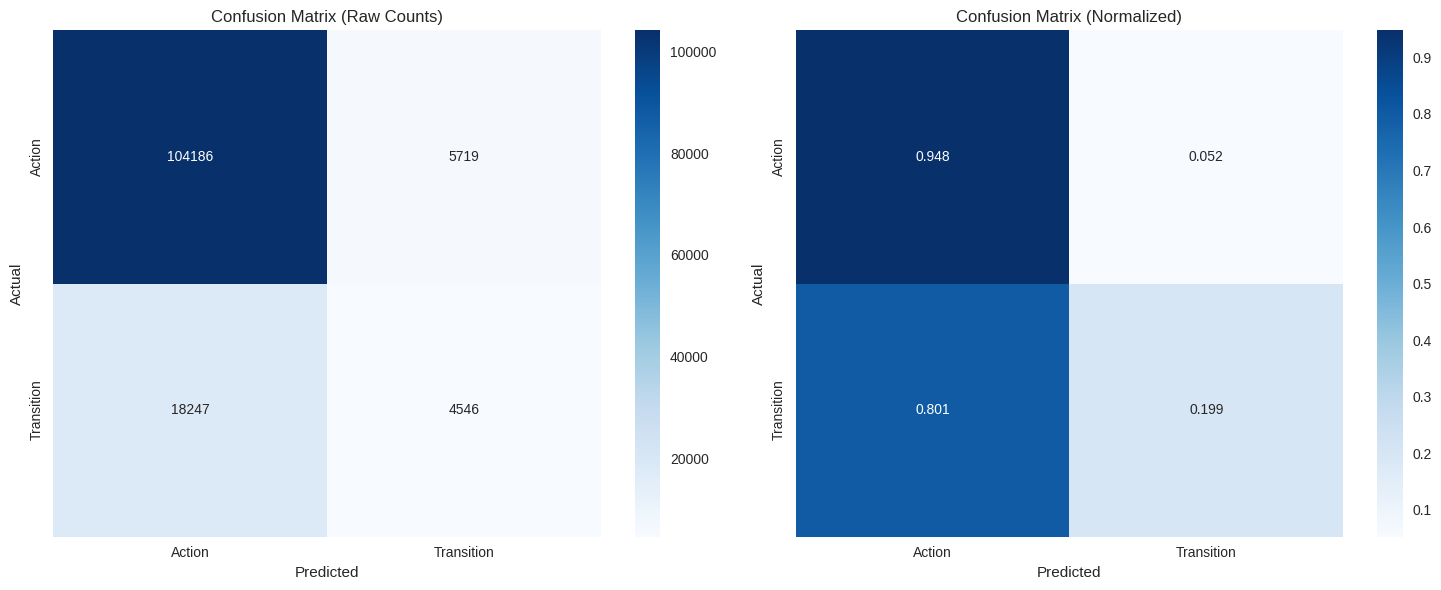

In [13]:
# Visualize confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Raw confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Action', 'Transition'], 
            yticklabels=['Action', 'Transition'])
ax1.set_title('Confusion Matrix (Raw Counts)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Normalized confusion matrix
confusion_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_norm, annot=True, fmt='.3f', cmap='Blues', ax=ax2,
            xticklabels=['Action', 'Transition'], 
            yticklabels=['Action', 'Transition'])
ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Error Analysis by Transition Characteristics

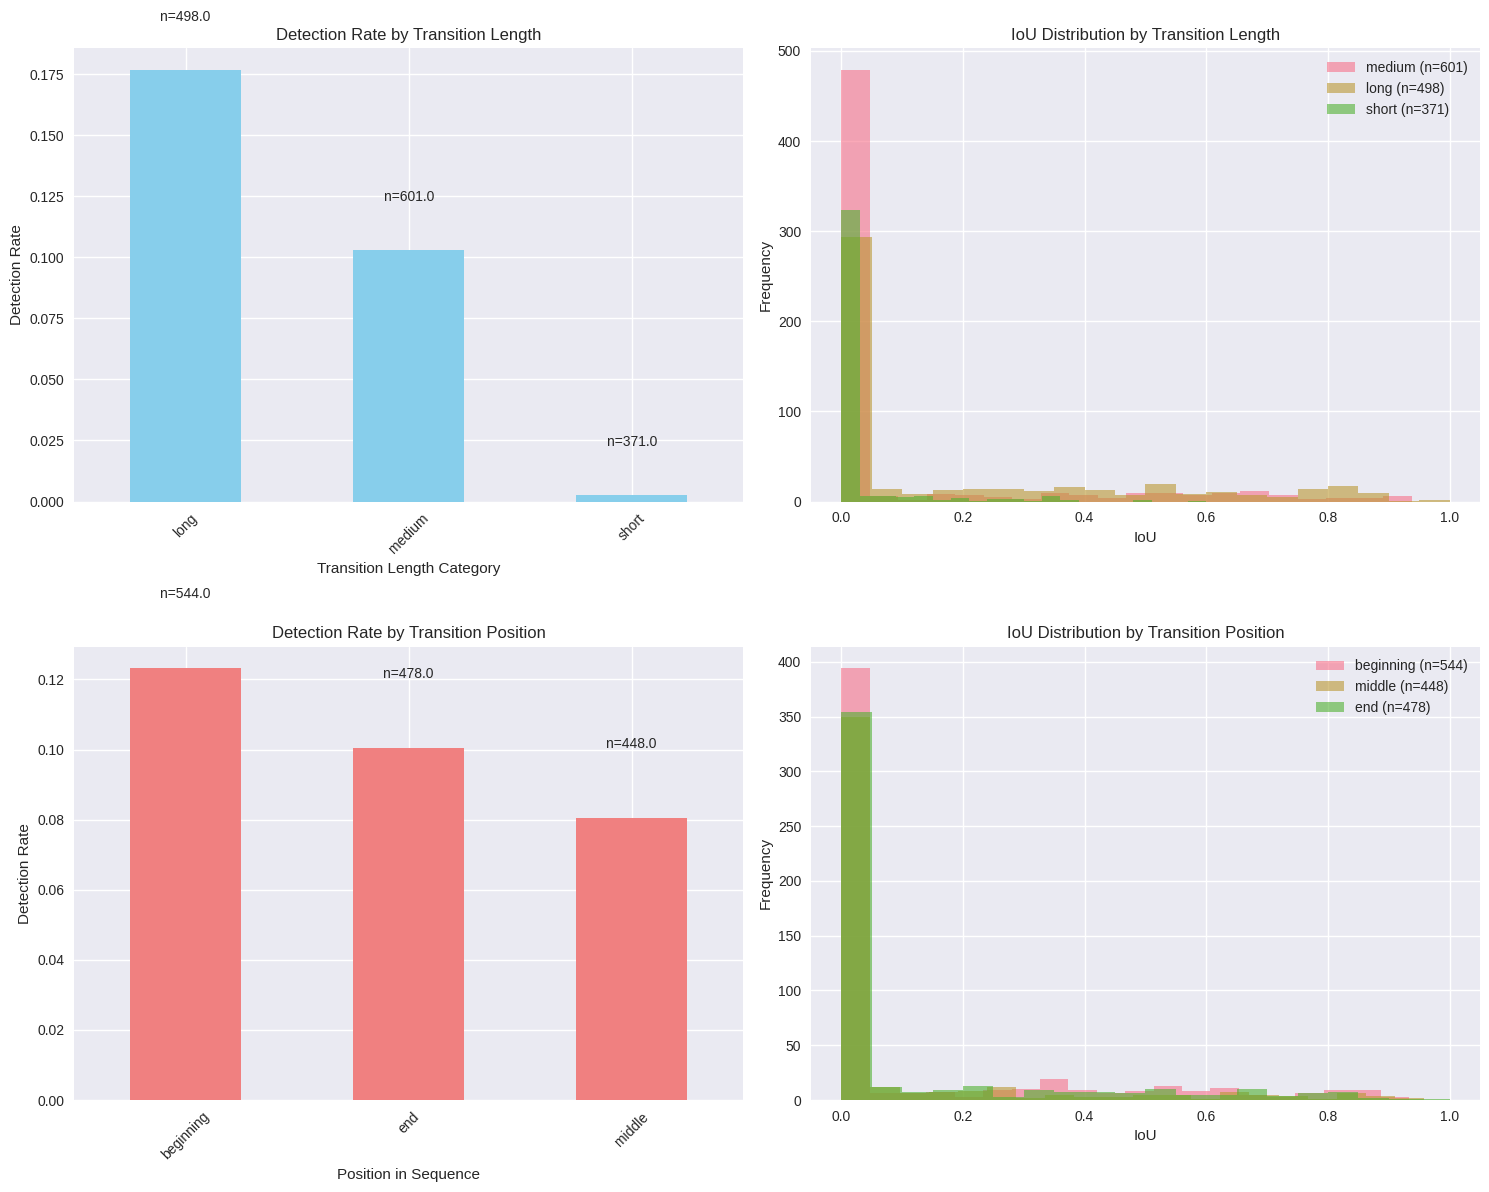

Detection Rate by Transition Length:
                   mean  count
gt_length_cat                 
long           0.176707    498
medium         0.103161    601
short          0.002695    371

Detection Rate by Transition Position:
                 mean  count
gt_position                 
beginning    0.123162    544
end          0.100418    478
middle       0.080357    448


In [14]:
# Analysis by transition length
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Detection rate by transition length category
detection_by_length = df.groupby('gt_length_cat')['detected'].agg(['mean', 'count'])
ax1 = axes[0, 0]
detection_by_length['mean'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Detection Rate by Transition Length')
ax1.set_ylabel('Detection Rate')
ax1.set_xlabel('Transition Length Category')
ax1.tick_params(axis='x', rotation=45)

# Add count annotations
for i, (idx, row) in enumerate(detection_by_length.iterrows()):
    ax1.text(i, row['mean'] + 0.02, f'n={row["count"]}', ha='center')

# IoU distribution by transition length
ax2 = axes[0, 1]
for length_cat in df['gt_length_cat'].unique():
    if pd.notna(length_cat):
        subset = df[df['gt_length_cat'] == length_cat]['best_iou']
        ax2.hist(subset, alpha=0.6, label=f'{length_cat} (n={len(subset)})', bins=20)
ax2.set_title('IoU Distribution by Transition Length')
ax2.set_xlabel('IoU')
ax2.set_ylabel('Frequency')
ax2.legend()

# Detection rate by transition position
detection_by_position = df.groupby('gt_position')['detected'].agg(['mean', 'count'])
ax3 = axes[1, 0]
detection_by_position['mean'].plot(kind='bar', ax=ax3, color='lightcoral')
ax3.set_title('Detection Rate by Transition Position')
ax3.set_ylabel('Detection Rate')
ax3.set_xlabel('Position in Sequence')
ax3.tick_params(axis='x', rotation=45)

# Add count annotations
for i, (idx, row) in enumerate(detection_by_position.iterrows()):
    ax3.text(i, row['mean'] + 0.02, f'n={row["count"]}', ha='center')

# IoU by position
ax4 = axes[1, 1]
for position in df['gt_position'].unique():
    if pd.notna(position):
        subset = df[df['gt_position'] == position]['best_iou']
        ax4.hist(subset, alpha=0.6, label=f'{position} (n={len(subset)})', bins=20)
ax4.set_title('IoU Distribution by Transition Position')
ax4.set_xlabel('IoU')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Detection Rate by Transition Length:")
print(detection_by_length)
print("\nDetection Rate by Transition Position:")
print(detection_by_position)

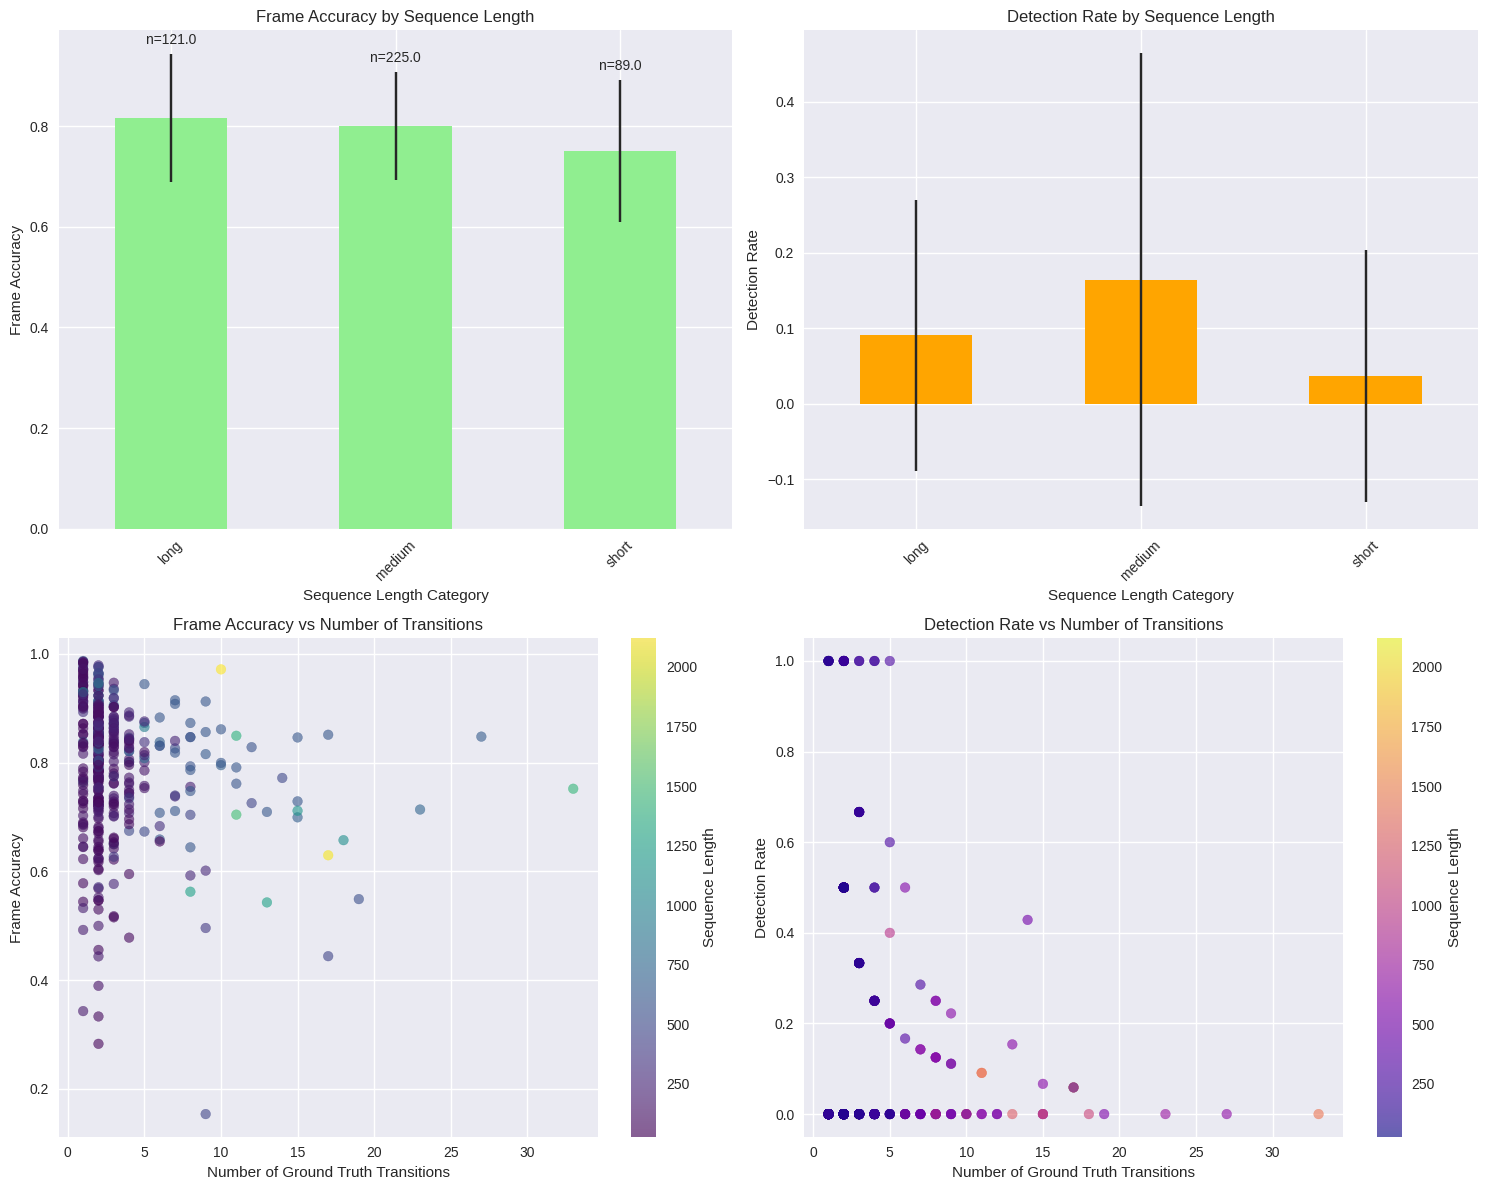

Frame Accuracy by Sequence Length:
                         mean       std  count
sequence_length_cat                           
long                 0.815984  0.126970    121
medium               0.799844  0.107933    225
short                0.750461  0.140986     89

Detection Rate by Sequence Length:
                         mean       std  count
sequence_length_cat                           
long                 0.090508  0.179092    121
medium               0.164430  0.300017    225
short                0.036517  0.166645     89


In [15]:
# Analysis by sequence characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Frame accuracy by sequence length
seq_stats = df.groupby('sequence_idx').agg({
    'sequence_length': 'first',
    'sequence_length_cat': 'first',
    'frame_accuracy': 'first',
    'num_gt_transitions': 'first',
    'detected': 'mean'  # Detection rate per sequence
}).reset_index()

# Frame accuracy by sequence length category
frame_acc_by_seq_length = seq_stats.groupby('sequence_length_cat')['frame_accuracy'].agg(['mean', 'std', 'count'])
ax1 = axes[0, 0]
frame_acc_by_seq_length['mean'].plot(kind='bar', ax=ax1, yerr=frame_acc_by_seq_length['std'], 
                                   capsize=5, color='lightgreen')
ax1.set_title('Frame Accuracy by Sequence Length')
ax1.set_ylabel('Frame Accuracy')
ax1.set_xlabel('Sequence Length Category')
ax1.tick_params(axis='x', rotation=45)

# Add count annotations
for i, (idx, row) in enumerate(frame_acc_by_seq_length.iterrows()):
    ax1.text(i, row['mean'] + row['std'] + 0.02, f'n={row["count"]}', ha='center')

# Detection rate by sequence length
detection_by_seq_length = seq_stats.groupby('sequence_length_cat')['detected'].agg(['mean', 'std', 'count'])
ax2 = axes[0, 1]
detection_by_seq_length['mean'].plot(kind='bar', ax=ax2, yerr=detection_by_seq_length['std'], 
                                   capsize=5, color='orange')
ax2.set_title('Detection Rate by Sequence Length')
ax2.set_ylabel('Detection Rate')
ax2.set_xlabel('Sequence Length Category')
ax2.tick_params(axis='x', rotation=45)

# Frame accuracy vs number of transitions
ax3 = axes[1, 0]
scatter = ax3.scatter(seq_stats['num_gt_transitions'], seq_stats['frame_accuracy'], 
                     alpha=0.6, c=seq_stats['sequence_length'], cmap='viridis')
ax3.set_title('Frame Accuracy vs Number of Transitions')
ax3.set_xlabel('Number of Ground Truth Transitions')
ax3.set_ylabel('Frame Accuracy')
plt.colorbar(scatter, ax=ax3, label='Sequence Length')

# Detection rate vs number of transitions
ax4 = axes[1, 1]
scatter2 = ax4.scatter(seq_stats['num_gt_transitions'], seq_stats['detected'], 
                      alpha=0.6, c=seq_stats['sequence_length'], cmap='plasma')
ax4.set_title('Detection Rate vs Number of Transitions')
ax4.set_xlabel('Number of Ground Truth Transitions')
ax4.set_ylabel('Detection Rate')
plt.colorbar(scatter2, ax=ax4, label='Sequence Length')

plt.tight_layout()
plt.show()

print("Frame Accuracy by Sequence Length:")
print(frame_acc_by_seq_length)
print("\nDetection Rate by Sequence Length:")
print(detection_by_seq_length)

## Detailed Error Patterns Analysis

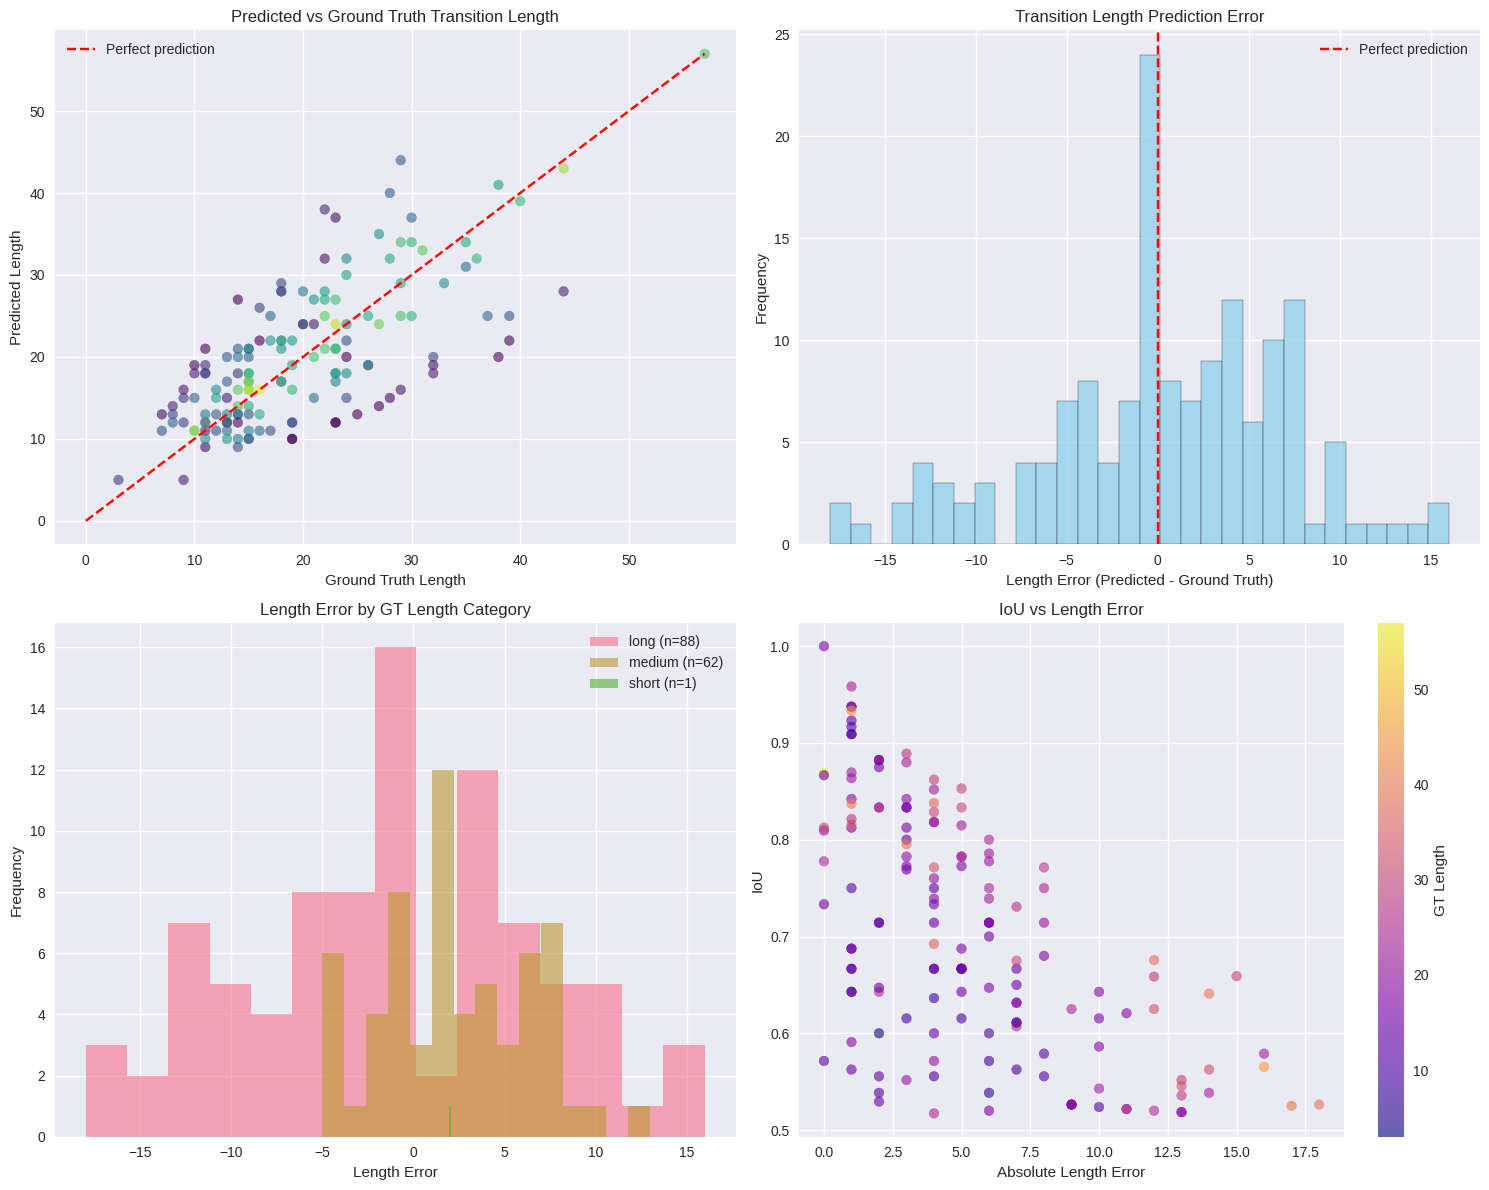

Mean length error: 0.26
Std length error: 6.71
Median length error: 1.00

Length error by category:
long: mean=-1.12, std=7.83
medium: mean=2.21, std=4.07
short: mean=2.00, std=nan


In [16]:
# Analyze relationship between predicted and ground truth transition lengths
detected_transitions = df[df['detected'] & df['pred_length'].notna()].copy()

if len(detected_transitions) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scatter plot: predicted vs ground truth length
    ax1 = axes[0, 0]
    ax1.scatter(detected_transitions['gt_length'], detected_transitions['pred_length'], 
               alpha=0.6, c=detected_transitions['best_iou'], cmap='viridis')
    ax1.plot([0, detected_transitions['gt_length'].max()], [0, detected_transitions['gt_length'].max()], 
            'r--', label='Perfect prediction')
    ax1.set_xlabel('Ground Truth Length')
    ax1.set_ylabel('Predicted Length')
    ax1.set_title('Predicted vs Ground Truth Transition Length')
    ax1.legend()
    
    # Length error distribution
    length_error = detected_transitions['pred_length'] - detected_transitions['gt_length']
    ax2 = axes[0, 1]
    ax2.hist(length_error, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Perfect prediction')
    ax2.set_xlabel('Length Error (Predicted - Ground Truth)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Transition Length Prediction Error')
    ax2.legend()
    
    # Length error by ground truth length category
    ax3 = axes[1, 0]
    for length_cat in detected_transitions['gt_length_cat'].unique():
        if pd.notna(length_cat):
            subset_error = length_error[detected_transitions['gt_length_cat'] == length_cat]
            ax3.hist(subset_error, alpha=0.6, label=f'{length_cat} (n={len(subset_error)})', bins=15)
    ax3.set_xlabel('Length Error')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Length Error by GT Length Category')
    ax3.legend()
    
    # IoU vs length error
    ax4 = axes[1, 1]
    scatter = ax4.scatter(abs(length_error), detected_transitions['best_iou'], 
                         alpha=0.6, c=detected_transitions['gt_length'], cmap='plasma')
    ax4.set_xlabel('Absolute Length Error')
    ax4.set_ylabel('IoU')
    ax4.set_title('IoU vs Length Error')
    plt.colorbar(scatter, ax=ax4, label='GT Length')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Mean length error: {length_error.mean():.2f}")
    print(f"Std length error: {length_error.std():.2f}")
    print(f"Median length error: {length_error.median():.2f}")
    print(f"\nLength error by category:")
    for cat in detected_transitions['gt_length_cat'].unique():
        if pd.notna(cat):
            cat_error = length_error[detected_transitions['gt_length_cat'] == cat]
            print(f"{cat}: mean={cat_error.mean():.2f}, std={cat_error.std():.2f}")
else:
    print("No detected transitions found for length analysis")

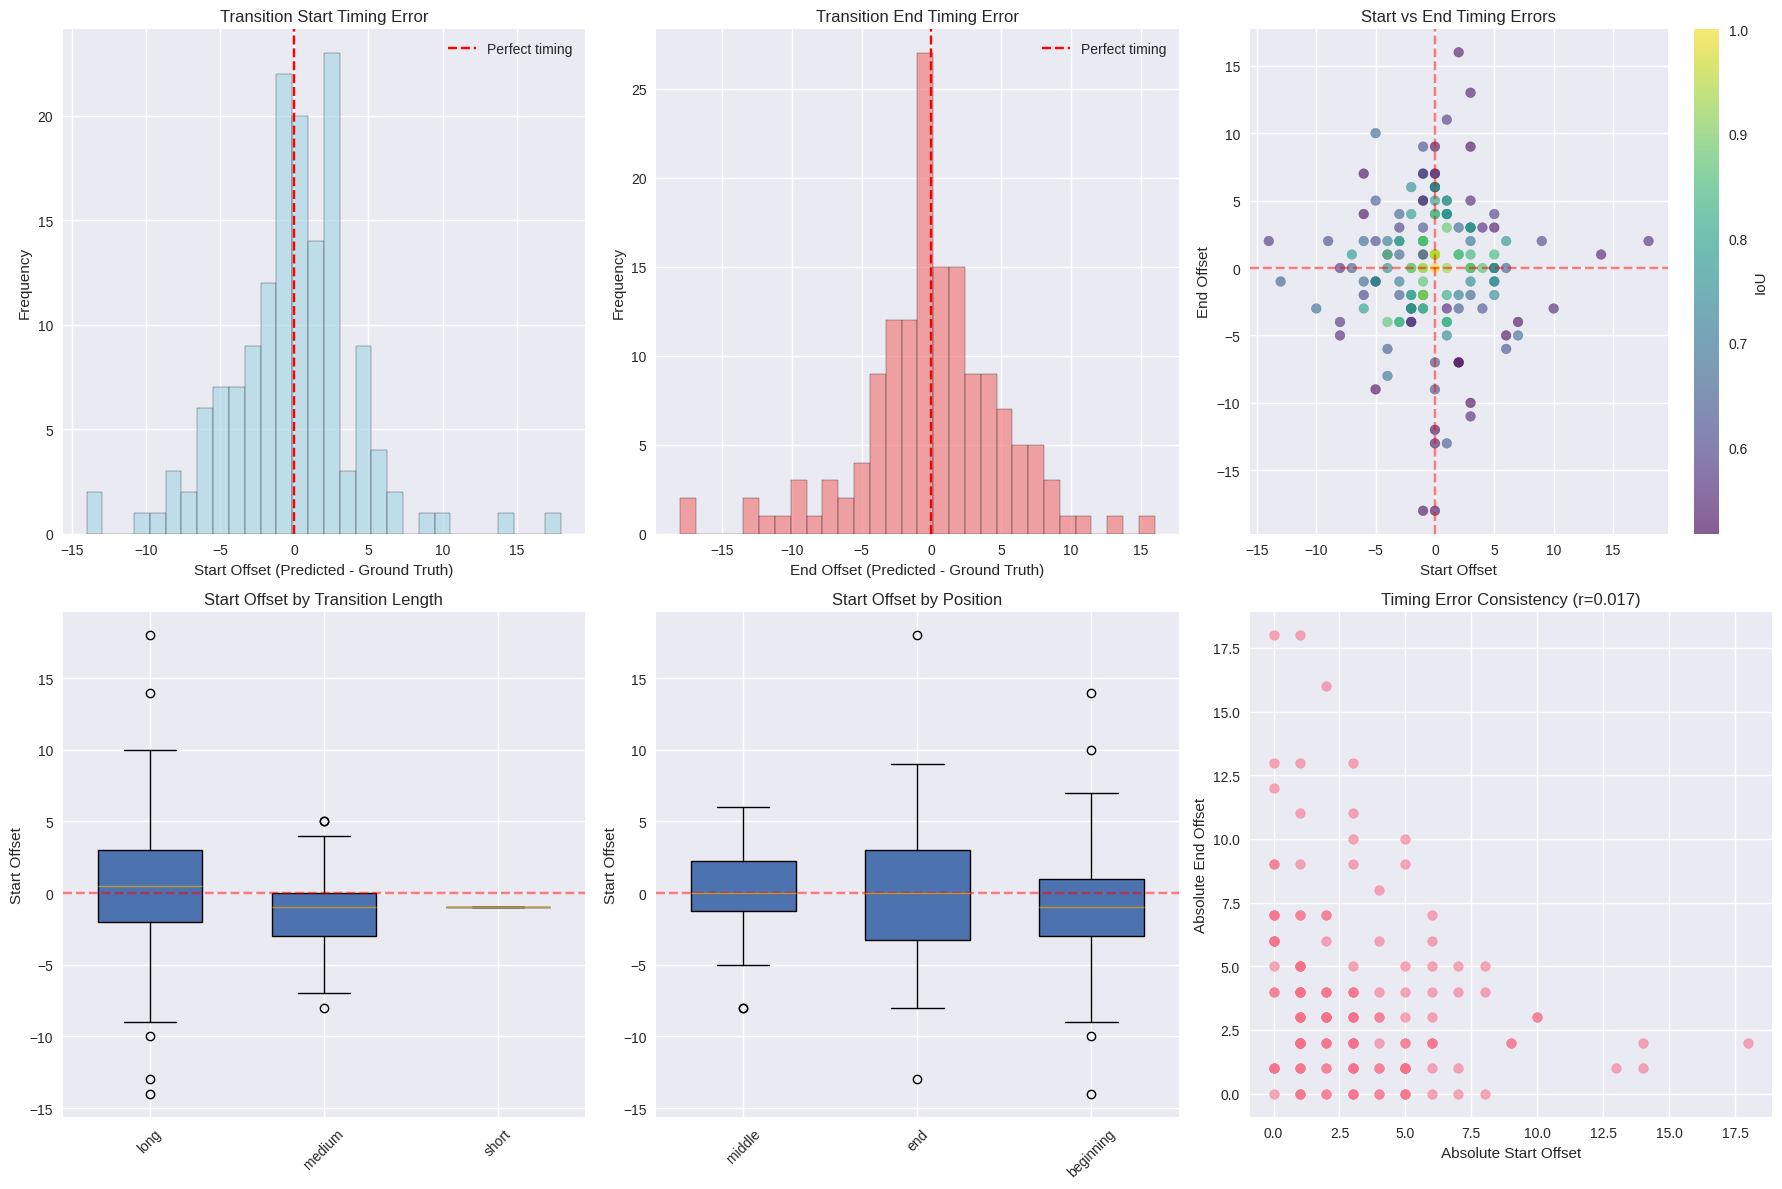

Start timing error: mean=-0.23, std=4.38
End timing error: mean=0.03, std=5.16
Start-End offset correlation: 0.017


In [17]:
# Analyze temporal offset patterns (start/end timing errors)
if len(detected_transitions) > 0:
    # Calculate start and end offsets
    start_offset = detected_transitions['pred_start'] - detected_transitions['gt_start']
    end_offset = detected_transitions['pred_end'] - detected_transitions['gt_end']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Start offset distribution
    ax1 = axes[0, 0]
    ax1.hist(start_offset, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    ax1.axvline(0, color='red', linestyle='--', label='Perfect timing')
    ax1.set_xlabel('Start Offset (Predicted - Ground Truth)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Transition Start Timing Error')
    ax1.legend()
    
    # End offset distribution
    ax2 = axes[0, 1]
    ax2.hist(end_offset, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Perfect timing')
    ax2.set_xlabel('End Offset (Predicted - Ground Truth)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Transition End Timing Error')
    ax2.legend()
    
    # Start vs end offset scatter
    ax3 = axes[0, 2]
    scatter = ax3.scatter(start_offset, end_offset, alpha=0.6, 
                         c=detected_transitions['best_iou'], cmap='viridis')
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Start Offset')
    ax3.set_ylabel('End Offset')
    ax3.set_title('Start vs End Timing Errors')
    plt.colorbar(scatter, ax=ax3, label='IoU')
    
    # Offset by transition length category
    ax4 = axes[1, 0]
    offset_by_length = []
    categories = detected_transitions['gt_length_cat'].unique()
    for i, cat in enumerate(categories):
        if pd.notna(cat):
            cat_start_offset = start_offset[detected_transitions['gt_length_cat'] == cat]
            ax4.boxplot(cat_start_offset, positions=[i], widths=0.6, patch_artist=True)
            offset_by_length.append(cat)
    ax4.set_xticklabels(offset_by_length, rotation=45)
    ax4.set_ylabel('Start Offset')
    ax4.set_title('Start Offset by Transition Length')
    ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Offset by position
    ax5 = axes[1, 1]
    positions = detected_transitions['gt_position'].unique()
    for i, pos in enumerate(positions):
        if pd.notna(pos):
            pos_start_offset = start_offset[detected_transitions['gt_position'] == pos]
            ax5.boxplot(pos_start_offset, positions=[i], widths=0.6, patch_artist=True)
    ax5.set_xticklabels(positions, rotation=45)
    ax5.set_ylabel('Start Offset')
    ax5.set_title('Start Offset by Position')
    ax5.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Timing consistency (start vs end offset correlation)
    ax6 = axes[1, 2]
    correlation = np.corrcoef(start_offset, end_offset)[0, 1]
    ax6.scatter(abs(start_offset), abs(end_offset), alpha=0.6)
    ax6.set_xlabel('Absolute Start Offset')
    ax6.set_ylabel('Absolute End Offset')
    ax6.set_title(f'Timing Error Consistency (r={correlation:.3f})')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Start timing error: mean={start_offset.mean():.2f}, std={start_offset.std():.2f}")
    print(f"End timing error: mean={end_offset.mean():.2f}, std={end_offset.std():.2f}")
    print(f"Start-End offset correlation: {correlation:.3f}")
else:
    print("No detected transitions found for timing analysis")

## False Positive and False Negative Analysis

Analyzing False Positives and False Negatives...


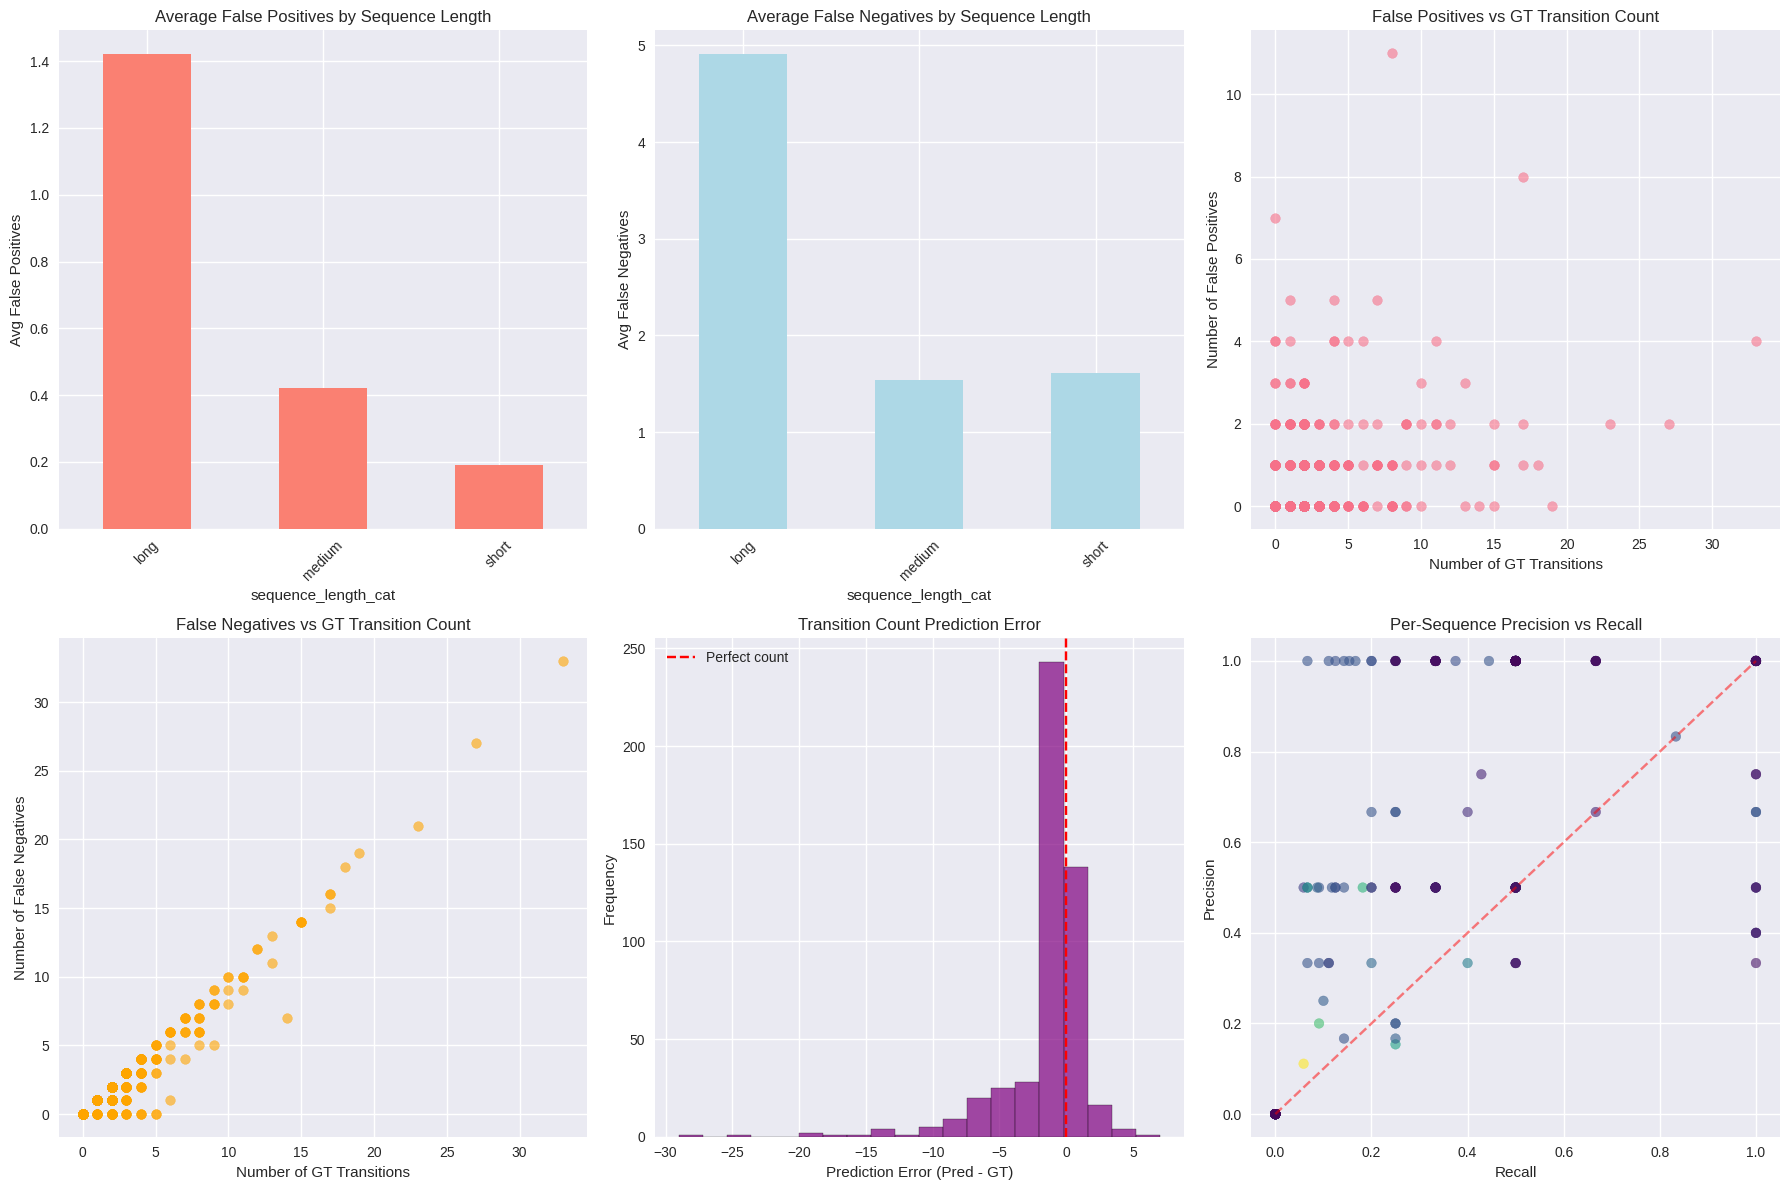

Total sequences analyzed: 500
Average false positives per sequence: 0.64
Average false negatives per sequence: 2.45

Sequences with no errors: 62
Sequences with only FP: 35
Sequences with only FN: 245
Sequences with both FP and FN: 158


In [18]:
# Analyze false positives and false negatives
print("Analyzing False Positives and False Negatives...")

# Calculate sequence-level statistics
sequence_analysis = []

for seq_idx in range(len(all_predictions)):
    gt = all_ground_truth[seq_idx]
    pred = all_predictions[seq_idx]
    
    # Get segments
    gt_segments = extract_segments(gt)
    pred_segments = extract_segments(pred)
    
    gt_transitions = [(start, end) for label, start, end in gt_segments if label == 1]
    pred_transitions = [(start, end) for label, start, end in pred_segments if label == 1]
    
    # Calculate false positives (predicted transitions not in ground truth)
    false_positives = []
    for pred_start, pred_end in pred_transitions:
        matched = False
        for gt_start, gt_end in gt_transitions:
            # Check overlap
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:  # Lower threshold for considering a match
                matched = True
                break
        if not matched:
            false_positives.append((pred_start, pred_end))
    
    # Calculate false negatives (ground truth transitions not predicted)
    false_negatives = []
    for gt_start, gt_end in gt_transitions:
        matched = False
        for pred_start, pred_end in pred_transitions:
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:
                matched = True
                break
        if not matched:
            false_negatives.append((gt_start, gt_end))
    
    sequence_analysis.append({
        'sequence_idx': seq_idx,
        'sequence_length': len(gt),
        'sequence_length_cat': categorize_sequence_length(len(gt)),
        'num_gt_transitions': len(gt_transitions),
        'num_pred_transitions': len(pred_transitions),
        'num_false_positives': len(false_positives),
        'num_false_negatives': len(false_negatives),
        'false_positives': false_positives,
        'false_negatives': false_negatives
    })

seq_df = pd.DataFrame(sequence_analysis)

# Visualize false positive/negative patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# False positive rate by sequence length
fp_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_positives': 'mean',
    'sequence_idx': 'count'
})
ax1 = axes[0, 0]
fp_by_length['num_false_positives'].plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Average False Positives by Sequence Length')
ax1.set_ylabel('Avg False Positives')
ax1.tick_params(axis='x', rotation=45)

# False negative rate by sequence length
fn_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_negatives': 'mean',
    'sequence_idx': 'count'
})
ax2 = axes[0, 1]
fn_by_length['num_false_negatives'].plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Average False Negatives by Sequence Length')
ax2.set_ylabel('Avg False Negatives')
ax2.tick_params(axis='x', rotation=45)

# FP vs number of ground truth transitions
ax3 = axes[0, 2]
ax3.scatter(seq_df['num_gt_transitions'], seq_df['num_false_positives'], alpha=0.6)
ax3.set_xlabel('Number of GT Transitions')
ax3.set_ylabel('Number of False Positives')
ax3.set_title('False Positives vs GT Transition Count')

# FN vs number of ground truth transitions
ax4 = axes[1, 0]
ax4.scatter(seq_df['num_gt_transitions'], seq_df['num_false_negatives'], alpha=0.6, color='orange')
ax4.set_xlabel('Number of GT Transitions')
ax4.set_ylabel('Number of False Negatives')
ax4.set_title('False Negatives vs GT Transition Count')

# Over/under prediction pattern
over_under = seq_df['num_pred_transitions'] - seq_df['num_gt_transitions']
ax5 = axes[1, 1]
ax5.hist(over_under, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax5.axvline(0, color='red', linestyle='--', label='Perfect count')
ax5.set_xlabel('Prediction Error (Pred - GT)')
ax5.set_ylabel('Frequency')
ax5.set_title('Transition Count Prediction Error')
ax5.legend()

# Precision vs Recall per sequence
seq_df['precision'] = seq_df.apply(lambda row: 
    (row['num_pred_transitions'] - row['num_false_positives']) / row['num_pred_transitions'] 
    if row['num_pred_transitions'] > 0 else 0, axis=1)

seq_df['recall'] = seq_df.apply(lambda row: 
    (row['num_gt_transitions'] - row['num_false_negatives']) / row['num_gt_transitions'] 
    if row['num_gt_transitions'] > 0 else 1, axis=1)

ax6 = axes[1, 2]
valid_sequences = (seq_df['num_gt_transitions'] > 0) & (seq_df['num_pred_transitions'] > 0)
if valid_sequences.any():
    ax6.scatter(seq_df[valid_sequences]['recall'], seq_df[valid_sequences]['precision'], 
               alpha=0.6, c=seq_df[valid_sequences]['sequence_length'], cmap='viridis')
    ax6.set_xlabel('Recall')
    ax6.set_ylabel('Precision')
    ax6.set_title('Per-Sequence Precision vs Recall')
    ax6.plot([0, 1], [0, 1], 'r--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total sequences analyzed: {len(seq_df)}")
print(f"Average false positives per sequence: {seq_df['num_false_positives'].mean():.2f}")
print(f"Average false negatives per sequence: {seq_df['num_false_negatives'].mean():.2f}")
print(f"\nSequences with no errors: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FP: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FN: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] > 0)])}")
print(f"Sequences with both FP and FN: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] > 0)])}")

## Summary and Recommendations

Based on the analysis above, we can identify patterns in model errors and suggest improvements:

In [19]:
# Generate comprehensive summary
print("=" * 80)
print("MOTION SEGMENTATION MODEL - ERROR ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n1. OVERALL PERFORMANCE:")
print(f"   • Frame-wise accuracy: {overall_accuracy:.3f}")
print(f"   • Transition detection rate: {detection_rate:.3f}")
print(f"   • Transition count accuracy: {np.mean(transition_count_accuracy):.3f}")
print(f"   • Transition F1-score: {class_report['Transition']['f1-score']:.3f}")

print(f"\n2. TRANSITION LENGTH ANALYSIS:")
if len(df) > 0:
    for length_cat in ['short', 'medium', 'long']:
        if length_cat in df['gt_length_cat'].values:
            cat_detection = df[df['gt_length_cat'] == length_cat]['detected'].mean()
            cat_count = len(df[df['gt_length_cat'] == length_cat])
            print(f"   • {length_cat.capitalize()} transitions ({cat_count} samples): {cat_detection:.3f} detection rate")

print(f"\n3. POSITION ANALYSIS:")
if len(df) > 0:
    for position in ['beginning', 'middle', 'end']:
        if position in df['gt_position'].values:
            pos_detection = df[df['gt_position'] == position]['detected'].mean()
            pos_count = len(df[df['gt_position'] == position])
            print(f"   • {position.capitalize()} transitions ({pos_count} samples): {pos_detection:.3f} detection rate")

print(f"\n4. SEQUENCE LENGTH IMPACT:")
if len(seq_stats) > 0:
    for seq_length_cat in ['short', 'medium', 'long']:
        if seq_length_cat in seq_stats['sequence_length_cat'].values:
            cat_accuracy = seq_stats[seq_stats['sequence_length_cat'] == seq_length_cat]['frame_accuracy'].mean()
            cat_count = len(seq_stats[seq_stats['sequence_length_cat'] == seq_length_cat])
            print(f"   • {seq_length_cat.capitalize()} sequences ({cat_count} samples): {cat_accuracy:.3f} frame accuracy")

print(f"\n5. ERROR PATTERNS:")
if len(detected_transitions) > 0:
    length_error = detected_transitions['pred_length'] - detected_transitions['gt_length']
    start_offset = detected_transitions['pred_start'] - detected_transitions['gt_start']
    end_offset = detected_transitions['pred_end'] - detected_transitions['gt_end']
    
    print(f"   • Mean length error: {length_error.mean():.2f} frames")
    print(f"   • Mean start timing error: {start_offset.mean():.2f} frames")
    print(f"   • Mean end timing error: {end_offset.mean():.2f} frames")
    
    # Identify if model tends to over or under-segment
    if length_error.mean() > 2:
        print(f"   • Model tends to OVER-segment transitions")
    elif length_error.mean() < -2:
        print(f"   • Model tends to UNDER-segment transitions")
    else:
        print(f"   • Model shows balanced segmentation")

print(f"\n6. FALSE POSITIVE/NEGATIVE ANALYSIS:")
print(f"   • Average false positives per sequence: {seq_df['num_false_positives'].mean():.2f}")
print(f"   • Average false negatives per sequence: {seq_df['num_false_negatives'].mean():.2f}")
print(f"   • Perfect sequences (no errors): {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] == 0)])} / {len(seq_df)}")

print(f"\n7. RECOMMENDATIONS:")

# Generate specific recommendations based on analysis
recommendations = []

if len(df) > 0:
    # Check transition length bias
    short_detection = df[df['gt_length_cat'] == 'short']['detected'].mean() if 'short' in df['gt_length_cat'].values else 0
    long_detection = df[df['gt_length_cat'] == 'long']['detected'].mean() if 'long' in df['gt_length_cat'].values else 0
    
    if short_detection < 0.7:
        recommendations.append("Improve detection of SHORT transitions - consider reducing window size or improving temporal resolution")
    
    if long_detection < 0.7:
        recommendations.append("Improve detection of LONG transitions - consider data augmentation with longer transitions")
    
    # Check position bias
    beginning_detection = df[df['gt_position'] == 'beginning']['detected'].mean() if 'beginning' in df['gt_position'].values else 0
    end_detection = df[df['gt_position'] == 'end']['detected'].mean() if 'end' in df['gt_position'].values else 0
    
    if beginning_detection < 0.7:
        recommendations.append("Improve detection of transitions at BEGINNING of sequences - check boundary effects")
    
    if end_detection < 0.7:
        recommendations.append("Improve detection of transitions at END of sequences - check boundary effects")

if len(detected_transitions) > 0:
    length_error = detected_transitions['pred_length'] - detected_transitions['gt_length']
    if abs(length_error.mean()) > 3:
        if length_error.mean() > 0:
            recommendations.append("Model over-segments transitions - consider post-processing to merge nearby predictions")
        else:
            recommendations.append("Model under-segments transitions - improve boundary detection accuracy")

if seq_df['num_false_positives'].mean() > 1:
    recommendations.append("High false positive rate - consider increasing classification threshold or improving vote aggregation")

if seq_df['num_false_negatives'].mean() > 0.5:
    recommendations.append("High false negative rate - consider decreasing classification threshold or improving feature extraction")

if class_report['Transition']['precision'] < 0.7:
    recommendations.append("Low precision - focus on reducing false positives through better classification or post-processing")

if class_report['Transition']['recall'] < 0.7:
    recommendations.append("Low recall - focus on reducing false negatives through better feature learning or data augmentation")

if len(recommendations) == 0:
    recommendations.append("Model performance is relatively balanced across different conditions")

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n" + "=" * 80)
print(f"Analysis completed on {len(all_predictions)} sequences with {len(results)} transitions")
print(f"Run directory: {RUN_DIR}")
print("=" * 80)

MOTION SEGMENTATION MODEL - ERROR ANALYSIS SUMMARY

1. OVERALL PERFORMANCE:
   • Frame-wise accuracy: 0.819
   • Transition detection rate: 0.103
   • Transition count accuracy: 0.344
   • Transition F1-score: 0.275

2. TRANSITION LENGTH ANALYSIS:
   • Short transitions (371 samples): 0.003 detection rate
   • Medium transitions (601 samples): 0.103 detection rate
   • Long transitions (498 samples): 0.177 detection rate

3. POSITION ANALYSIS:
   • Beginning transitions (544 samples): 0.123 detection rate
   • Middle transitions (448 samples): 0.080 detection rate
   • End transitions (478 samples): 0.100 detection rate

4. SEQUENCE LENGTH IMPACT:
   • Short sequences (89 samples): 0.750 frame accuracy
   • Medium sequences (225 samples): 0.800 frame accuracy
   • Long sequences (121 samples): 0.816 frame accuracy

5. ERROR PATTERNS:
   • Mean length error: 0.26 frames
   • Mean start timing error: -0.23 frames
   • Mean end timing error: 0.03 frames
   • Model shows balanced segmentat